In [7]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [8]:
%load_ext autoreload
%autoreload 2
from datetime import datetime
import importlib
import numpy as np
import logging
import os
import shutil
from typing import Any
import yaml
from rdkit import RDLogger
from generator import Generator
from language import Language
from node import MolSentenceNode
from utils import add_sep, class_from_package, make_logger

RDLogger.DisableLog('rdApp.*') # use debug: true to log invalid mols

def read_yaml(yaml_path: str) -> tuple[Generator, dict[str, Any]]:
    with open(os.path.join(repo_root, yaml_path)) as f:
        conf = yaml.safe_load(f)

    output_dir=os.path.join(repo_root, "sandbox", conf["output_dir"], datetime.now().strftime("%m-%d_%H-%M")) + os.sep
    file_level = logging.DEBUG if conf.get("debug") else logging.INFO
    logger = make_logger(output_dir, file_level=file_level)
    generator_args = conf.get("generator_args", {})

    transition_args = conf.get("transition_args", {})
    if "model_dir" in transition_args:
        transition_args["model_dir"] = os.path.join(repo_root, transition_args["model_dir"])
    lang_path = conf.get("lang_path")
    if lang_path is None:
        lang_name = os.path.basename(os.path.normpath(transition_args["model_dir"])) + ".lang"
        lang_path = add_sep(transition_args["model_dir"]) + lang_name
    lang = Language.load(lang_path)
    transition_class = class_from_package("transition", conf["transition_class"])
    transition = transition_class(lang=lang, logger=logger, device=conf.get("device"), **transition_args)

    reward_class = class_from_package("reward", conf.get("reward_class"))
    reward = reward_class(**conf.get("reward_args", {}))
    
    if "policy_class" in conf:
        policy_class = class_from_package("policy", conf.get("policy_class"))
        policy = policy_class(**conf.get("policy_args", {}))
        generator_args["policy"] = policy

    filter_settings = conf.get("filters", [])
    filters = []
    for s in filter_settings:
        filter_class = class_from_package("filter", s.pop("filter_class"))
        filters.append(filter_class(**s))
        
    root = MolSentenceNode.bos_node(lang, device=conf.get("device")) # TODO: change after root node generalization
    
    generator_class = class_from_package("generator", conf.get("generator_class", "MCTS"))
    generator = generator_class(root=root, transition=transition, reward=reward, filters=filters, output_dir=output_dir, logger=logger, **generator_args)

    src = os.path.join(repo_root, yaml_path)
    dst = os.path.join(output_dir, "setting.yaml")
    shutil.copy(src, dst)
    return generator, conf

def generate_and_analyze(generator, conf):
    generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))
    generator.plot(**conf.get("plot_args", {}))
    generator.analyze()

def queue_generations(*args: str):
    for yaml_path in args:
        generator, conf = read_yaml(yaml_path)
        generate_and_analyze(generator, conf)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Is CUDA available: True
Starting generation...
<best reward updated> order: 1, time: 0.00, reward: 0.0000, node: C(C)(C)[C@H](CNC(=O)N1CCCC[C@H]1C[NH+]1CCCC1)NC(=O)NC1CC1
<best reward updated> order: 2, time: 0.00, reward: 0.1396, node: C(C)CCN1C(=O)c2cc3ccccc3n2C[C@@]1(C)C(=O)Nc1ccc(C(F)(F)F)cc1
<best reward updated> order: 3, time: 0.00, reward: 0.2864, node: C(C)Cc1n[nH]c(C(=O)NCc2ccc(-n3ccnc3)nc2)n1
<best reward updated> order: 10, time: 0.00, reward: 0.3338, node: OCC[NH2+]C/C=C/c1cccc(F)c1F
<best reward updated> order: 12, time: 0.00, reward: 0.4070, node: OC1CCC2(CC1)OCC[C@@]2(O)c1cncc(Br)c1
<best reward updated> order: 13, time: 0.00, reward: 0.4093, node: OCc1ccc(O[C@@H]2CCOC3(CCCC3)C2)cc1
<best reward updated> order: 55, time: 1.26, reward: 0.4884, node: O[C@@H]1CCC[NH+]([C@H]2CCOC3(CCCC3)C2)C1
generated: 100, time: 2.69, average over 100: 0.2071
generated: 200, time: 5.71, average over 100: 0.2799
generated: 300, time: 9.07, average over 100: 0.2448
generated: 400, time: 12.

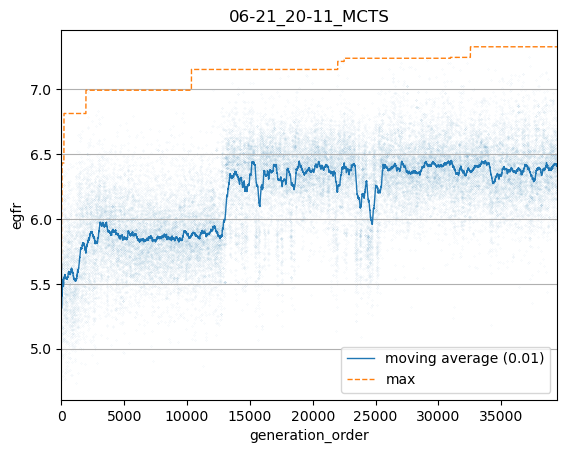

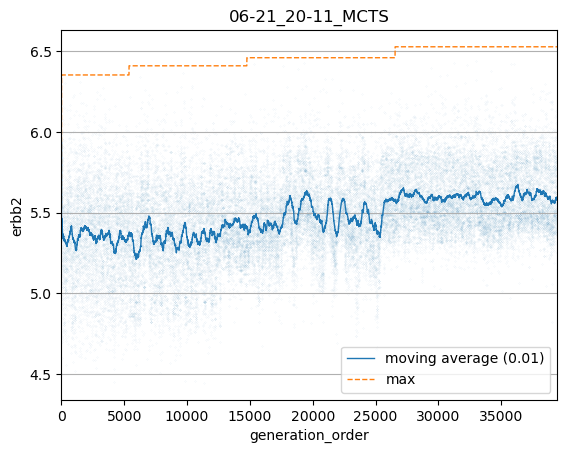

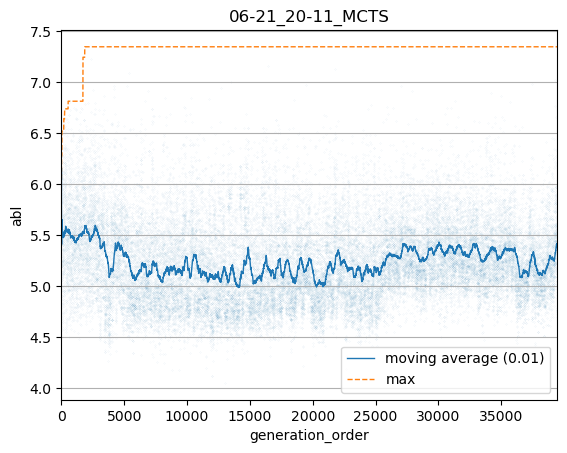

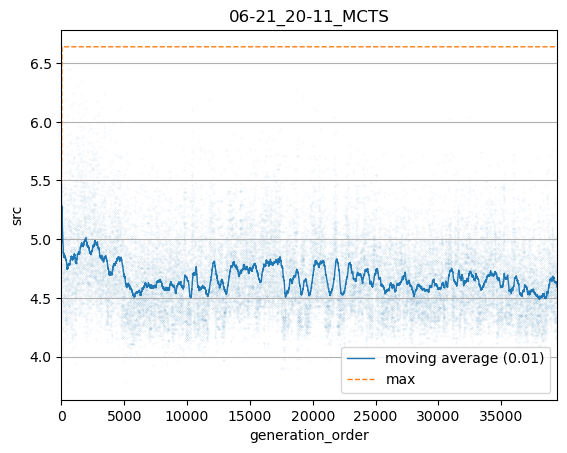

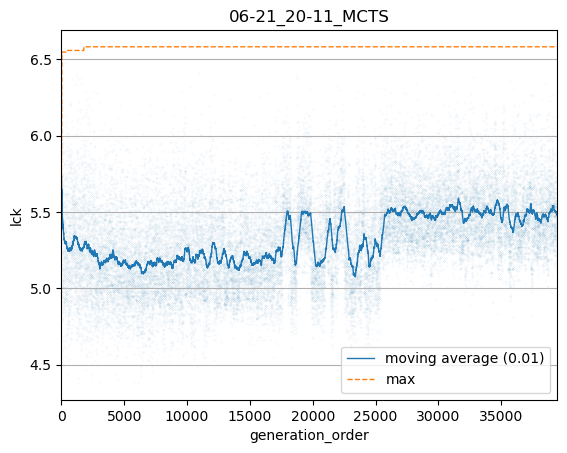

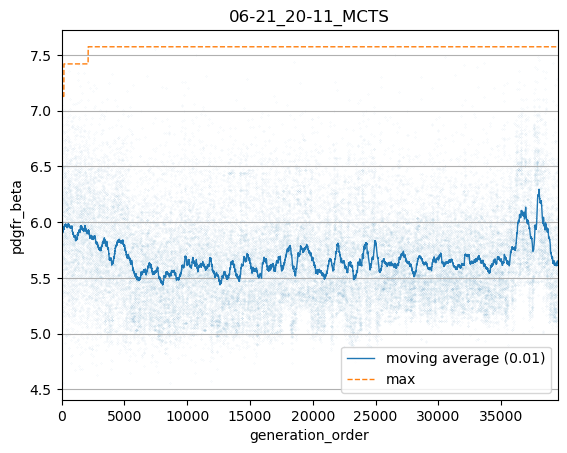

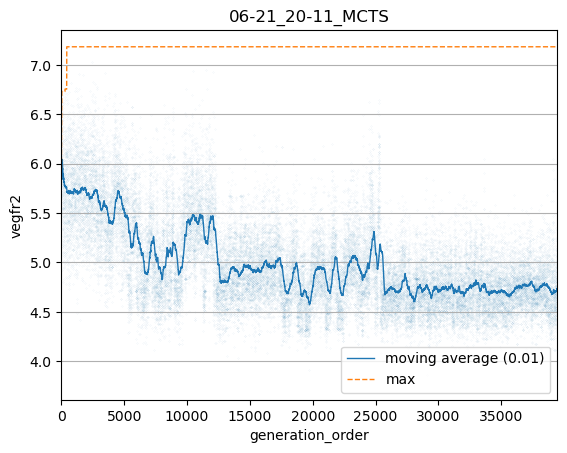

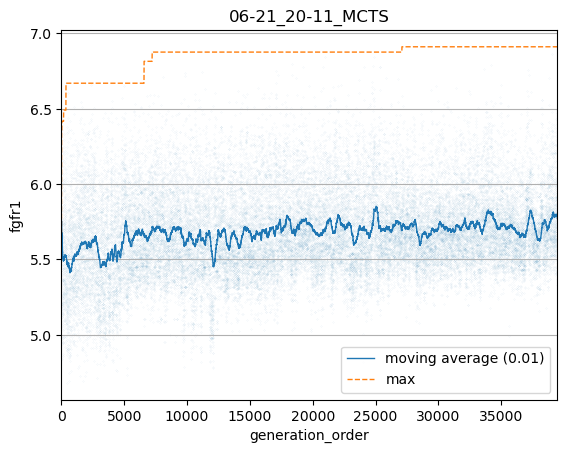

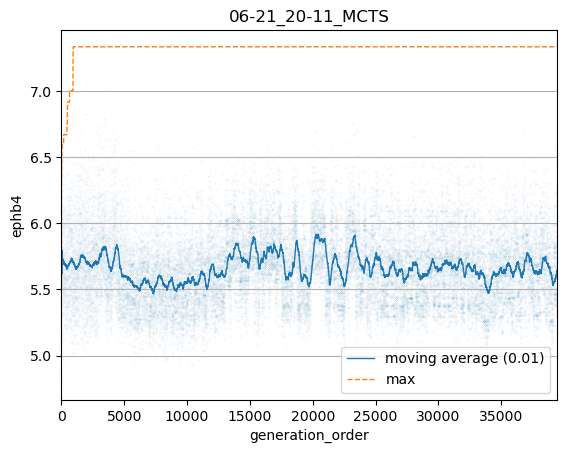

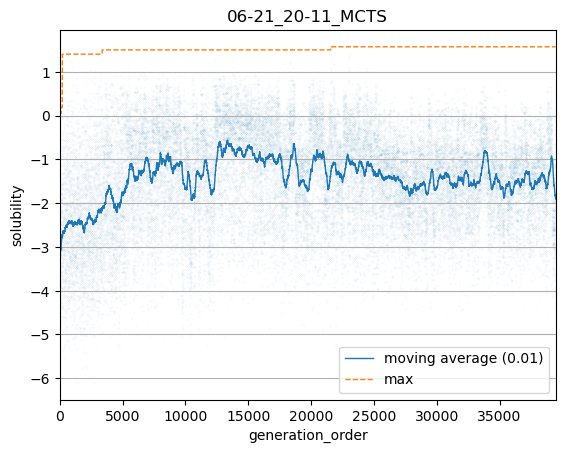

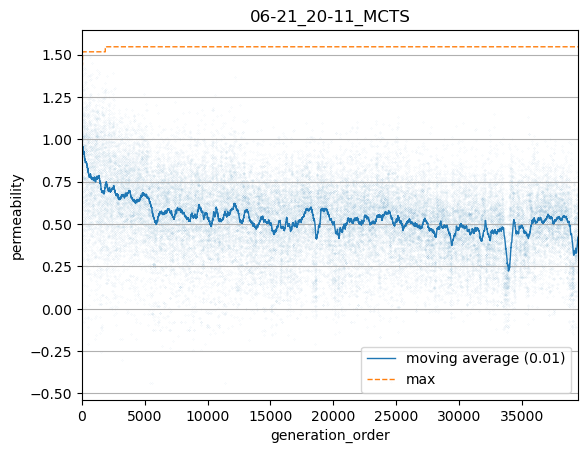

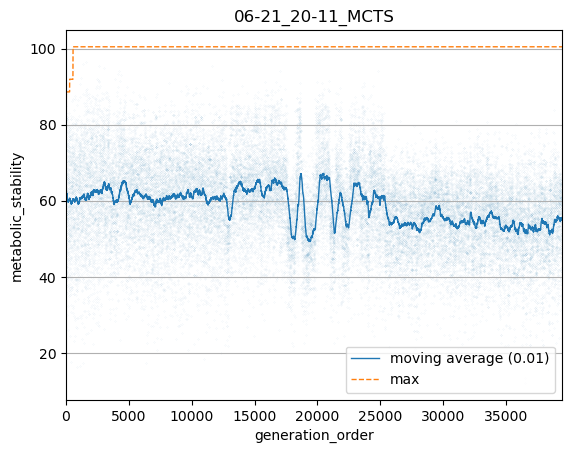

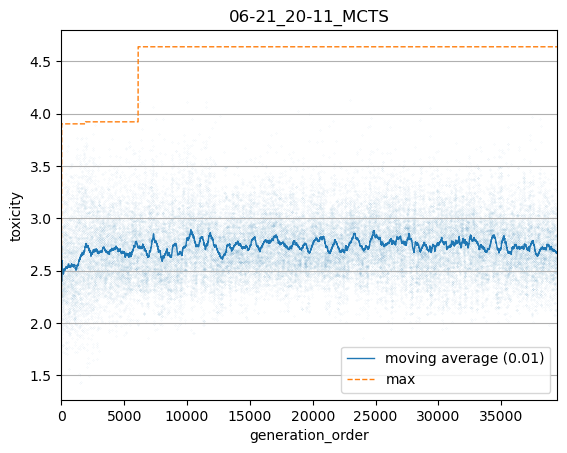

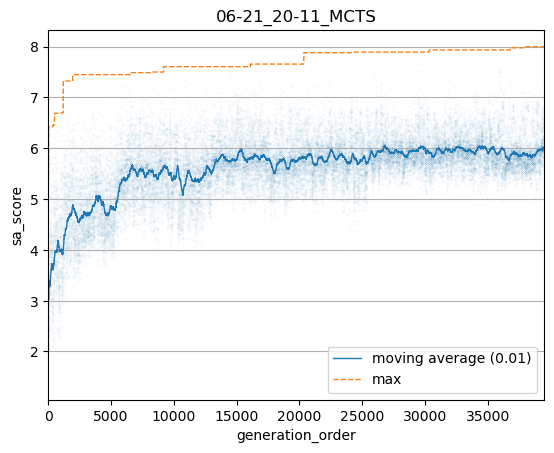

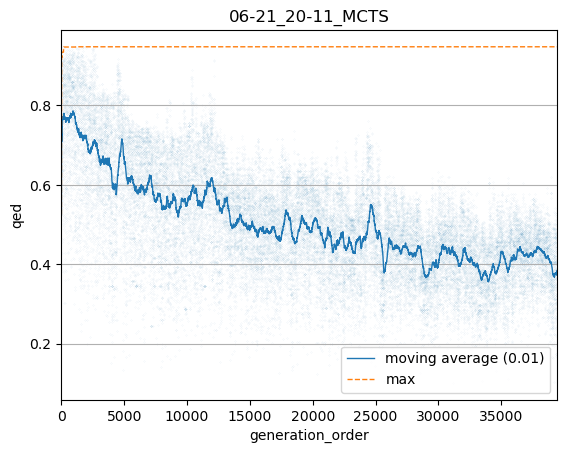

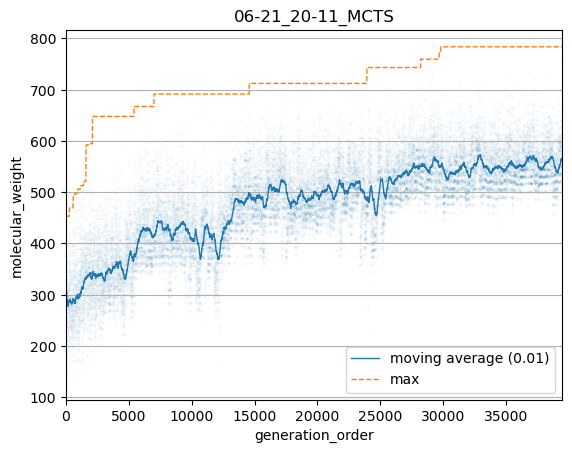

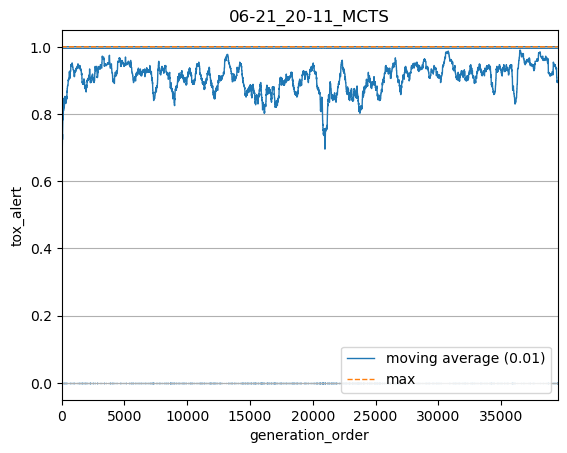

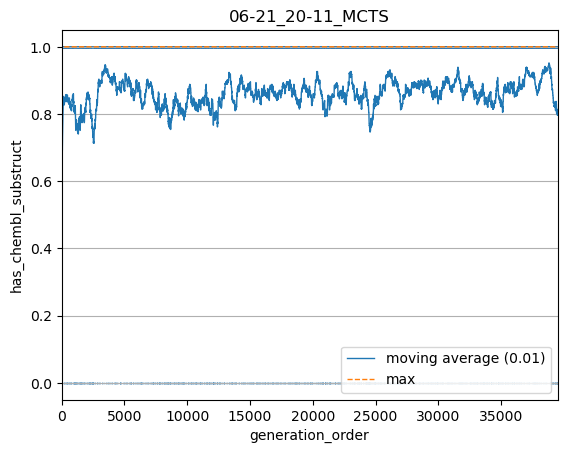

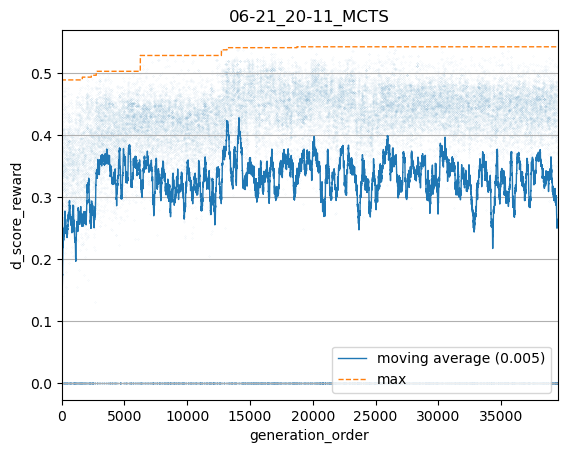

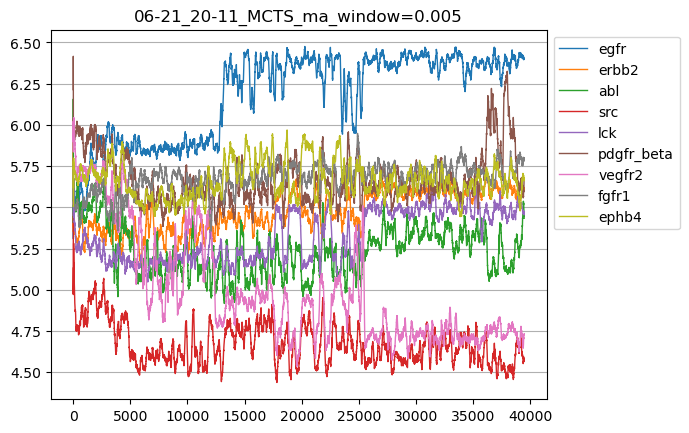

number of generated nodes: 39475
valid rate: 0.4416004764717656
unique rate: 0.7511167307006966
node_per_sec: 18.876978873154695


In [10]:
c1 = "config/mcts_d_score_replication.yaml"
c2 = "config/mcts_helm.yaml"
c3 = "config/mcts_smiles.yaml"
c4 = "config/model_test.yaml"
c5 = "config/mcts_d_score.yaml"
generator, conf = read_yaml(c5)
generate_and_analyze(generator, conf)
# queue_generations(c1, c2)

In [ ]:
#continue search
generator.generate(time_limit=conf.get("time_limit") - generator.passed_time, max_generations=conf.get("max_generations") - len(generator.unique_keys))
generator.plot(**conf.get("plot_args", {}))
generator.analyze()

In [ ]:
#save mcts
save_path = generator.output_dir() + "save.mcts"
generator.save(save_path)

In [ ]:
#load mcts test
load_path = generator.output_dir() + "save.mcts"
generator = MCTS.load(load_path, generator.transition) #TODO: separate notebook

In [ ]:
#time test
import cProfile
import pstats

profiler = cProfile.Profile()
profiler.enable()
read_yaml(c2)
profiler.disable()

stats = pstats.Stats(profiler)
stats.sort_stats("cumtime").print_stats(100)